# 0. Setup

In [1]:
!hostname

gl1012.arc-ts.umich.edu


In [2]:
# code cleanup
# wandb / logging
# use all voxels for training?
# optimize
# mess with architecture

In [ ]:
import os
import gc
import glob
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim2d
from skimage.metrics import peak_signal_noise_ratio as psnr2d
import wandb

import torchio as tio
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🟢 Using device: {device}")

🟢 Using device: cuda


In [ ]:
from anatomix.model.network import Unet

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

# load_dotenv()
# data_dir_root = os.getenv("DATA_DIR")
# data_dir = "/scratch/jjparkcv_root/jjparkcv98/minsukc/SynthRAD2025/Task1"
root_dir = "/home/minsukc/MRI2CT"
ckpt_dir = os.path.join(root_dir, "anatomix", "model-weights", "anatomix.pth")

print(root_dir, ckpt_dir)

/home/minsukc/MRI2CT /home/minsukc/MRI2CT/anatomix/model-weights/anatomix.pth


In [ ]:
data_dir = "/home/minsukc/MRI2CT/anatomix_registration_outputs"
# SUBJ_ID = "1BB098_256x256x128"
SUBJ_ID = "1ABA005_128x128x128"

EPOCHS = 200
# EPOCHS = 3
LR = 3e-4
BATCH_SIZE = 131_072
VAL_INTERVAL = 5
NOW = datetime.now().strftime("%Y%m%d_%H%M%S")

In [ ]:
# Initialize Weights & Biases
wandb.init(
    project="mri2ct",
    name=f"run_{SUBJ_ID}_{NOW}",
    config={
        "epochs": EPOCHS,
        "learning_rate": LR,
        "batch_size": BATCH_SIZE,
        "subject_id": SUBJ_ID,
        "val_interval": VAL_INTERVAL,
        "model": "MLPTranslator",
        "feature_extractor": "Anatomix_Unet",
    },
)


# 1. Helper functions

In [ ]:
def cleanup_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()


def minmax(arr, minclip=None, maxclip=None):
    if not (minclip is None and maxclip is None):
        arr = np.clip(arr, minclip, maxclip)
    arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
    return arr


def find_image(root, subj_id, name):
    # base = os.path.join(root, subj_id.replace("_", "/"))
    base = os.path.join(root, subj_id)
    matches = glob.glob(os.path.join(base, f"{name}.nii*"))
    # matches = glob.glob(os.path.join(base, f"{name}.mha")) + glob.glob(
    #     os.path.join(base, f"{name}.nii*")
    # )
    if not matches:
        raise FileNotFoundError(f"{name}.nii* file not found for {subj_id}")
    return matches[0]


def compute_metrics(pred, target):
    """pred/target: [H,W,D] in [0,1]"""
    mae = np.mean(np.abs(pred - target))
    psnrs, ssims = [], []
    for z in range(pred.shape[2]):
        psnrs.append(psnr2d(target[..., z], pred[..., z], data_range=1.0))
        ssims.append(ssim2d(target[..., z], pred[..., z], data_range=1.0))
    return mae, np.mean(psnrs), np.mean(ssims)


def load_image_pair(root, subj_id):
    ct_path = find_image(root, subj_id, "ct")
    mr_path = find_image(root, subj_id, "moved_mr*")
    # mr_path = find_image(root, subj_id, "mr")
    # mask_path = find_image(root, subj_id, "mask")

    mr_img = tio.ScalarImage(mr_path)
    ct_img = tio.ScalarImage(ct_path)

    mri = mr_img.data[0].numpy()
    ct = ct_img.data[0].numpy()

    mri = minmax(mri)
    ct = minmax(ct, minclip=-450, maxclip=450)
    print("MRI shape:", mri.shape, "CT shape:", ct.shape)
    return mri, ct

# 2. Load dataset (one subject)

In [ ]:
mri, ct = load_image_pair(data_dir, SUBJ_ID)

MRI shape: (128, 128, 128) CT shape: (128, 128, 128)


# 3. Load Anatomix model and extract features

In [ ]:
model = Unet(
    dimension=3,
    input_nc=1,
    output_nc=16,
    num_downs=4,
    ngf=16,
).to(device)

model.load_state_dict(torch.load(ckpt_dir, map_location=device), strict=True)
print("✅ Loaded anatomix pretrained model")

Encoder skip connect id [8, 15, 22, 29]
Decoder skip connect id [37, 44, 51, 58]
✅ Loaded anatomix pretrained model


In [ ]:
@torch.no_grad()
def extract_feats(volume_np, model, device):
    inp = torch.from_numpy(volume_np[None, None]).float().to(device)
    feats = model(inp)
    return feats.squeeze(0).cpu().numpy()  # [C,H,W,D]


feats_mri = extract_feats(mri, model, device)
cleanup_gpu()
feats_ct = extract_feats(ct, model, device)
print(f"✅ MRI feats: {feats_mri.shape}, CT feats: {feats_ct.shape}")
C, H, W, D = feats_mri.shape

✅ MRI feats: (16, 128, 128, 128), CT feats: (16, 128, 128, 128)


# 4. Prepare voxel-wise dataset

In [ ]:
X = torch.from_numpy(feats_mri).permute(1, 2, 3, 0).reshape(-1, 16).float()
# Y = torch.from_numpy(feats_ct).permute(1, 2, 3, 0).reshape(-1, 16)
Y = torch.from_numpy(ct).reshape(-1, 1).float()  # [N,1]
print(f"Total voxels: {len(X):,}")

Total voxels: 2,097,152


In [ ]:
# max_vox = 500_000
# if len(X) > max_vox:
#     idx = torch.randperm(len(X))[:max_vox]
#     X, Y = X[idx], Y[idx]

dataset = TensorDataset(X, Y)
loader = DataLoader(
    dataset,
    # batch_size=4096,
    # batch_size=65_536,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers=2,
    # persistent_workers=True,
)

# 5. Simple translator model (MLP or Conv)

In [ ]:
class MLPTranslator(nn.Module):
    def __init__(self, in_dim=16, hidden=64, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim),
            nn.Sigmoid(),  # TODO: try with and without
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# class Conv1x1Translator(nn.Module):
#     """1x1x1 convolutional translator — equivalent to a linear layer shared across voxels"""

#     def __init__(self, in_dim=16, out_dim=1):
#         super().__init__()
#         self.conv = nn.Conv3d(in_dim, out_dim, kernel_size=1)
#         self.act = nn.Sigmoid()

#     def forward(self, x):  # x: [B,16,H,W,D]
#         y = self.conv(x)
#         return self.act(y)


# use_conv = False
# model_t = (
#     Conv1x1Translator(16, 16).to(device) if use_conv else MLPTranslator().to(device)
# )

model_t = MLPTranslator().to(device)
optimizer = torch.optim.Adam(model_t.parameters(), lr=LR)
loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()

# 6. Training loop

In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for xb, yb in tqdm(loader, position=1, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, feats_mri, ct, device):
    model.eval()
    X_full = torch.from_numpy(feats_mri).permute(1, 2, 3, 0).reshape(-1, 16).to(device)
    preds = []
    for i in range(0, X_full.size(0), 100_000):
        preds.append(model(X_full[i : i + 100_000]).cpu().numpy())
    pred_ct = np.concatenate(preds, axis=0).reshape(ct.shape)
    return compute_metrics(pred_ct, ct), pred_ct


def visualize_ct_prediction(ct_gt, ct_pred, epoch=None, num_slices=3, log_wandb=False):
    """
    Compare ground-truth and predicted CT slices with an error map.

    Args:
        ct_gt (np.ndarray): Ground-truth CT volume [H, W, D].
        ct_pred (np.ndarray): Predicted CT volume [H, W, D].
        epoch (int, optional): Epoch number for title/logging.
        num_slices (int): Number of evenly spaced slices to show.
        log_wandb (bool): If True, logs the figure to Weights & Biases.
    """

    def norm(x):
        x = x - x.min()
        return x / (x.max() + 1e-8)

    slices = np.linspace(0, ct_gt.shape[-1] - 1, num_slices, dtype=int)
    fig, axes = plt.subplots(num_slices, 3, figsize=(12, 4 * num_slices))

    vmax = 1.0  # consistent scaling since images are normalized
    for i, z in enumerate(slices):
        gt_slice = norm(ct_gt[..., z])
        pred_slice = norm(ct_pred[..., z])
        diff_slice = np.abs(gt_slice - pred_slice)

        # Ground truth
        axes[i, 0].imshow(gt_slice, cmap="gray", vmin=0, vmax=vmax)
        axes[i, 0].set_title(f"GT CT (z={z})")
        axes[i, 0].axis("off")

        # Prediction
        axes[i, 1].imshow(pred_slice, cmap="gray", vmin=0, vmax=vmax)
        axes[i, 1].set_title("Predicted CT")
        axes[i, 1].axis("off")

        # Error map
        im = axes[i, 2].imshow(diff_slice, cmap="inferno", vmin=0, vmax=1)
        axes[i, 2].set_title("|GT - Pred| (Error map)")
        axes[i, 2].axis("off")

    # Add shared colorbar for error magnitude
    cbar_ax = fig.add_axes([0.92, 0.1, 0.015, 0.8])
    fig.colorbar(im, cax=cbar_ax, label="Error magnitude")

    title = "CT Prediction Comparison"
    if epoch is not None:
        title += f" — Epoch {epoch}"
    plt.suptitle(title, fontsize=16, y=0.93)
    plt.tight_layout(rect=[0, 0, 0.9, 0.93])
    plt.show()

    if log_wandb:
        wandb.log({f"ct_vis_epoch_{epoch or 'final'}": wandb.Image(fig)})

    plt.close(fig)


In [ ]:
# for epoch in range(EPOCHS):
for epoch in tqdm(range(1, EPOCHS + 1), desc="Training Progress", position=0):
    train_loss = train_one_epoch(model_t, loader, optimizer, loss_fn, device)
    wandb.log({"train_loss": train_loss, "epoch": epoch})
    if epoch % VAL_INTERVAL == 0:
        (mae, psnr, ssim), pred_ct = evaluate(model_t, feats_mri, ct, device)
        wandb.log({"mae": mae, "psnr": psnr, "ssim": ssim, "epoch": epoch})
        print(f"Epoch {epoch:03d} → MAE={mae:.4f}, PSNR={psnr:.2f}, SSIM={ssim:.3f}")

        visualize_ct_prediction(ct, pred_ct, epoch=epoch, log_wandb=True)


Training Progress:   0%|                                                                                                                                                                                            | 0/200 [00:02<?, ?it/s]


KeyboardInterrupt: 

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


wandb: 
wandb: 🚀 View run run_1ABA005_128x128x128_20251111_101858 at: 
wandb: Find logs at: wandb/run-20251111_101858-gswxrzi1/logs


In [ ]:
model_t.train()

for epoch in range(EPOCHS):
    total_loss = 0.0
    loop = tqdm(loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=False)

    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device)
        pred = model_t(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        loop.set_postfix(loss=loss.item())  # show live batch loss
        wandb.log({"batch_loss": loss.item()})

    avg_loss = total_loss / len(loader.dataset)
    wandb.log({"epoch": epoch + 1, "epoch_loss": avg_loss})
    print(f"Epoch {epoch + 1:02d}/{EPOCHS} - Loss: {avg_loss:.6f}")

print("✅ Training complete!")


Epoch 01/300 - Loss: 0.026794


Epoch 02/300 - Loss: 0.023235


Epoch 03/300 - Loss: 0.021720


Epoch 04/300 - Loss: 0.020622


Epoch 05/300 - Loss: 0.019651


Epoch 06/300 - Loss: 0.018690


Epoch 07/300 - Loss: 0.017760


Epoch 08/300 - Loss: 0.016906


Epoch 09/300 - Loss: 0.016174


Epoch 10/300 - Loss: 0.015570


Epoch 11/300 - Loss: 0.015067


Epoch 12/300 - Loss: 0.014642


Epoch 13/300 - Loss: 0.014269


Epoch 14/300 - Loss: 0.013949


Epoch 15/300 - Loss: 0.013675


Epoch 16/300 - Loss: 0.013437


Epoch 17/300 - Loss: 0.013230


Epoch 18/300 - Loss: 0.013047


Epoch 19/300 - Loss: 0.012880


Epoch 20/300 - Loss: 0.012722


Epoch 21/300 - Loss: 0.012569


Epoch 22/300 - Loss: 0.012424


Epoch 23/300 - Loss: 0.012284


Epoch 24/300 - Loss: 0.012150


Epoch 25/300 - Loss: 0.012020


Epoch 26/300 - Loss: 0.011896


Epoch 27/300 - Loss: 0.011777


Epoch 28/300 - Loss: 0.011662


Epoch 29/300 - Loss: 0.011551


Epoch 30/300 - Loss: 0.011445


Epoch 31/300 - Loss: 0.011343


Epoch 32/300 - Loss: 0.011242


Epoch 33/300 - Loss: 0.011148


Epoch 34/300 - Loss: 0.011054


Epoch 35/300 - Loss: 0.010964


Epoch 36/300 - Loss: 0.010878


Epoch 37/300 - Loss: 0.010793


Epoch 38/300 - Loss: 0.010711


Epoch 39/300 - Loss: 0.010632


Epoch 40/300 - Loss: 0.010556


Epoch 41/300 - Loss: 0.010483


Epoch 42/300 - Loss: 0.010408


Epoch 43/300 - Loss: 0.010335


Epoch 44/300 - Loss: 0.010263


Epoch 45/300 - Loss: 0.010193


Epoch 46/300 - Loss: 0.010124


Epoch 47/300 - Loss: 0.010055


Epoch 48/300 - Loss: 0.009991


Epoch 49/300 - Loss: 0.009924


Epoch 50/300 - Loss: 0.009863


Epoch 51/300 - Loss: 0.009799


Epoch 52/300 - Loss: 0.009741


Epoch 53/300 - Loss: 0.009682


Epoch 54/300 - Loss: 0.009626


Epoch 55/300 - Loss: 0.009570


Epoch 56/300 - Loss: 0.009517


Epoch 57/300 - Loss: 0.009463


Epoch 58/300 - Loss: 0.009415


Epoch 59/300 - Loss: 0.009363


Epoch 60/300 - Loss: 0.009312


Epoch 61/300 - Loss: 0.009263


Epoch 62/300 - Loss: 0.009219


Epoch 63/300 - Loss: 0.009179


Epoch 64/300 - Loss: 0.009138


Epoch 65/300 - Loss: 0.009087


Epoch 66/300 - Loss: 0.009045


Epoch 67/300 - Loss: 0.009004


KeyboardInterrupt: 

In [ ]:
save_path = os.path.join(
    root_dir, "results/single_pair_optimization", f"mri2ct_simple_model_{NOW}.pt"
)
torch.save(model_t.state_dict(), save_path)
print(f"💾 Saved to {save_path}")

💾 Saved to /home/minsukc/MRI2CT/results/single_pair_optimization/mri2ct_simple_model_20251111_023516.pt


# 7. Evaluate: reconstruct predicted CT features

In [ ]:
model_t.eval()
with torch.no_grad():
    X_full = torch.from_numpy(feats_mri).permute(1, 2, 3, 0).reshape(-1, 16).to(device)
    preds = []
    for i in range(0, X_full.size(0), 100_000):
        preds.append(model_t(X_full[i : i + 100_000]).cpu().numpy())
    pred_ct = np.concatenate(preds, axis=0).reshape(H, W, D)

mae, psnr, ssim = compute_metrics(pred_ct, ct)
wandb.log(
    {
        "mae": mae,
        "psnr": psnr,
        "ssim": ssim,
    }
)
print("✅ Predicted CT features:", pred_ct.shape)
print(f"✅ Overfit results → MAE={mae:.4f}, PSNR={psnr:.2f}, SSIM={ssim:.3f}")

✅ Predicted CT features: (128, 128, 128)
✅ Overfit results → MAE=0.0542, PSNR=23.75, SSIM=0.603


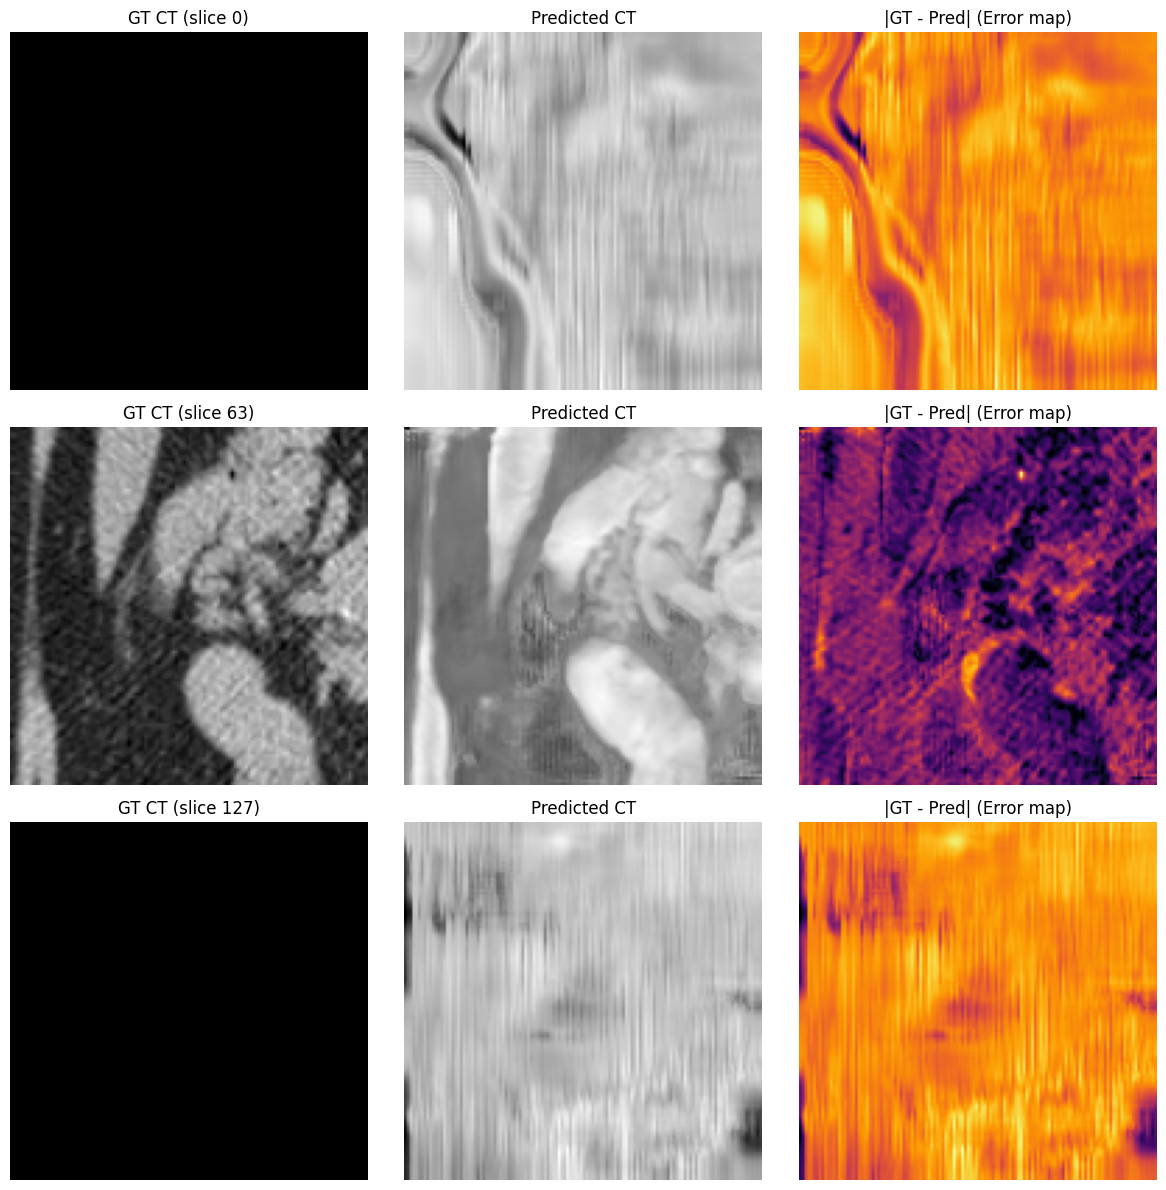

In [ ]:
visualize_ct_prediction(ct, pred_ct, epoch="final", log_wandb=True)